In [16]:
import numpy as np
import pandas as pd

class DatosAgricolas:
    """
    Simulación de datos para productos agrícolas perecederos
    con eventos de mercado, comportamientos de brokers y variables climáticas.
    """
    def __init__(self, params, n_dias=1000, factor=1000):
        self.n_dias = n_dias
        self.fechas = pd.date_range(start="2023-01-01", periods=n_dias, freq='D')
        self.df = None
        self.eventos = None
        
        # frambuesa
        self.m_precio_frambuesa = params['precio_frambuesa']/factor
        self.m_precio_frambuesa_var = params['precio_frambuesa_var']/factor
        self.m_volumen_frambuesa = params['volumen_frambuesa']/factor
        self.m_volumen_frambuesa_var = params['volumen_frambuesa_var']/factor
        # aguacate
        self.m_precio_aguacate = params['precio_aguacate']/factor
        self.m_precio_aguacate_var = params['precio_aguacate_var']/factor
        self.m_volumen_aguacate = params['volumen_aguacate']/factor
        self.m_volumen_aguacate_var = params['volumen_aguacate_var']/factor
        # chile
        self.m_precio_chile = params['precio_chile']/factor
        self.m_precio_chile_var = params['precio_chile_var']/factor
        self.m_volumen_chile = params['volumen_chile']/factor
        self.m_volumen_chile_var = params['volumen_chile_var']/factor

    def generar_base(self):
        """
        Genera datos base para los productos
        """
        tiempo = np.linspace(0, 10, self.n_dias)
        estacionalidad = np.sin(2 * np.pi * tiempo / 365) * 0.2

        # Variables climáticas
        temperatura = 25 + 10 * np.sin(2 * np.pi * tiempo / 365) + np.random.normal(0, 3, size=self.n_dias)
        humedad = 60 + 20 * np.sin(2 * np.pi * tiempo / 365 + np.pi/2) + np.random.normal(0, 5, size=self.n_dias)

        # Series muy smooth para TDA (solo sinusoidal + ruido gaussiano leve)
        ruido_precio = np.random.normal(0, 0.005 * self.m_precio_frambuesa, size=self.n_dias)
        precio_frambuesa = self.m_precio_frambuesa * (1 + 0.3 * np.sin(2 * np.pi * tiempo / 365)) + ruido_precio

        ruido_volumen = np.random.normal(0, 0.02 * self.m_volumen_frambuesa, size=self.n_dias)
        volumen_frambuesa = self.m_volumen_frambuesa * (1 + 0.2 * np.sin(2 * np.pi * tiempo / 365 + np.pi/4)) + ruido_volumen

        calidad_frambuesa = np.clip(0.9 - 0.005*(temperatura-25)**2 - 0.002*(humedad-70)**2 + np.random.normal(0, 0.02, size=self.n_dias), 0.5, 1.0)

        # Aguacate y chile - comportamiento normal
        precio_aguacate = np.exp(np.random.normal(self.m_precio_aguacate + estacionalidad * 0.5, self.m_precio_aguacate_var, size=self.n_dias))
        volumen_aguacate = np.random.normal(self.m_volumen_aguacate, self.m_volumen_aguacate_var, size=self.n_dias)
        calidad_aguacate = np.clip(0.95 - 0.003*(temperatura-22)**2 + np.random.normal(0, 0.03, size=self.n_dias), 0.7, 1.0)

        precio_chile = np.exp(np.random.normal(self.m_precio_chile + estacionalidad * 0.001, self.m_precio_chile_var, size=self.n_dias))
        volumen_chile = np.random.normal(self.m_volumen_chile, self.m_volumen_chile_var, size=self.n_dias)
        calidad_chile = np.clip(0.85 - 0.001*(humedad-50)**2 + np.random.normal(0, 0.04, size=self.n_dias), 0.6, 1.0)

        datos = {
            'fecha': self.fechas,
            'precio_frambuesa': precio_frambuesa,
            'volumen_frambuesa': volumen_frambuesa,
            'calidad_frambuesa': calidad_frambuesa,
            'precio_aguacate': precio_aguacate,
            'volumen_aguacate': volumen_aguacate,
            'calidad_aguacate': calidad_aguacate,
            'precio_chile': precio_chile,
            'volumen_chile': volumen_chile,
            'calidad_chile': calidad_chile,
            'temperatura': temperatura,
            'humedad': humedad,
        }

        return pd.DataFrame(datos)

    def agregar_eventos_mercado(self, df):
        eventos = np.zeros(self.n_dias)
        return df, eventos  # No se agregan eventos en la versión base

    def simular_comportamiento_brokers(self, df):
        df['estrategia_broker'] = 'neutral'
        return df

    def generar_datos(self):
        df = self.generar_base()
        df, eventos = self.agregar_eventos_mercado(df)
        df = self.simular_comportamiento_brokers(df)

        df['precio_fresa'] = df['precio_frambuesa'] * np.random.uniform(0.8, 1.2)
        df.loc[df['precio_frambuesa'] > df['precio_frambuesa'].quantile(0.8), 'precio_fresa'] *= 1.1

        self.df = df
        self.eventos = eventos
        return df, eventos

class DatosAgricolasMejorado(DatosAgricolas):
    def agregar_eventos_mercado(self, df):
        eventos = np.zeros(self.n_dias)

        # Frambuesa - Buyers/Sellers cycle
        for i in range(150, self.n_dias-200, 250):
            duracion = np.random.randint(60, 120)
            if i + duracion > self.n_dias:
                duracion = self.n_dias - i - 1

            fase1 = i + duracion//3
            incremento_precio = np.linspace(1, 1.05, fase1-i+1)[:-1]  # más suave (antes 1.8)
            decremento_volumen = np.linspace(1, 0.9, fase1-i+1)[:-1]  # más suave (antes 0.6)
            df.loc[i:fase1-1, 'precio_frambuesa'] *= incremento_precio
            df.loc[i:fase1-1, 'volumen_frambuesa'] *= decremento_volumen

            fase2 = i + (2*duracion)//3
            transicion_precio = np.linspace(1.05, 1.02, fase2-fase1+1)[:-1]  # más suave
            transicion_volumen = np.linspace(0.9, 0.95, fase2-fase1+1)[:-1]  # más suave
            df.loc[fase1:fase2-1, 'precio_frambuesa'] *= transicion_precio
            df.loc[fase1:fase2-1, 'volumen_frambuesa'] *= transicion_volumen

            decremento_precio = np.linspace(1.02, 0.98, i+duracion-fase2+1)[:-1]  # más suave
            incremento_volumen = np.linspace(0.95, 1.05, i+duracion-fase2+1)[:-1]  # más suave
            df.loc[fase2:i+duracion-1, 'precio_frambuesa'] *= decremento_precio
            df.loc[fase2:i+duracion-1, 'volumen_frambuesa'] *= incremento_volumen

            eventos[i:i+duracion] = 1


        # Aguacate
        for i in range(200, self.n_dias-150, 300):
            duracion = np.random.randint(30, 50)
            if i + duracion > self.n_dias:
                continue
            intensidad = np.random.uniform(1.5, 2.5)
            mitad = duracion // 2
            df.loc[i:i+mitad-1, 'precio_aguacate'] *= intensidad
            df.loc[i+mitad:i+duracion-1, 'precio_aguacate'] /= intensidad
            df.loc[i:i+duracion-1, 'volumen_aguacate'] *= 0.7

        # Climáticos
        for i in range(100, self.n_dias-100, 350):
            duracion = np.random.randint(20, 40)
            if i + duracion > self.n_dias:
                continue
            df.loc[i:i+duracion-1, 'temperatura'] += np.random.uniform(5, 8)
            df.loc[i:i+duracion-1, 'humedad'] -= np.random.uniform(10, 20)

        return df, eventos

    def simular_comportamiento_brokers(self, df):
        df['estrategia_broker'] = 'neutral'
        df['fase_mercado'] = 'neutro'

        mask_sellers = (df['precio_frambuesa'].pct_change(7) > 0.15) & (df['volumen_frambuesa'].pct_change(7) < -0.1)
        mask_buyers = (df['precio_frambuesa'].pct_change(7) < -0.1) & (df['volumen_frambuesa'].pct_change(7) > 0.15)

        df.loc[mask_sellers, 'estrategia_broker'] = 'acumulacion_agresiva'
        df.loc[mask_buyers, 'estrategia_broker'] = 'liquidacion_rapida'

        mask_clima_extremo = (df['temperatura'] > 32) | (df['humedad'] < 40)
        df.loc[mask_clima_extremo, 'estrategia_broker'] = 'precaucion_extrema'

        return df


In [17]:
def generar_datasets(params, n_series=100, n_dias=1000):
    series_con_cambio = []
    series_sin_cambio = []

    for i in range(n_series//2):
        gen = DatosAgricolasMejorado(params, n_dias=n_dias)
        df, eventos = gen.generar_datos()
        df['serie_id'] = f"con_cambio_{i+1}"
        df['has_market_change'] = 1
        series_con_cambio.append(df)

    for i in range(n_series//2):
        gen = DatosAgricolas(params, n_dias=n_dias)
        df, eventos = gen.generar_datos()
        df['serie_id'] = f"sin_cambio_{i+1}"
        df['has_market_change'] = 0
        series_sin_cambio.append(df)

    full_dataset = pd.concat(series_con_cambio + series_sin_cambio, ignore_index=True)
    return full_dataset


In [18]:
params = {
    'precio_frambuesa': 70745,
    'precio_frambuesa_var': 2122,
    'volumen_frambuesa': 190000,
    'volumen_frambuesa_var': 11400,
    'precio_aguacate': 20212,
    'precio_aguacate_var': 3840,
    'volumen_aguacate': 2973000,
    'volumen_aguacate_var': 505000,
    'precio_chile': 22490,
    'precio_chile_var': 787,
    'volumen_chile': 3681000,
    'volumen_chile_var': 662580,
}

# Generar dataset
full_dataset = generar_datasets(params, n_series=100, n_dias=1000)

# Revisar distribución
print(full_dataset.groupby('has_market_change').size())

# Guardar si quieres exportar para TDA
full_dataset.to_csv("datos_agricolas_tda.csv", index=False)


has_market_change
0    50000
1    50000
dtype: int64


In [19]:
full_dataset.head()

,fecha,precio_frambuesa,volumen_frambuesa,calidad_frambuesa,precio_aguacate,volumen_aguacate,calidad_aguacate,precio_chile,volumen_chile,calidad_chile,temperatura,humedad,estrategia_broker,fase_mercado,precio_fresa,serie_id,has_market_change
0,2023-01-01,70.559162,215.035239,0.731640,1.528536e+07,2610.302997,0.974015,1.657639e+10,3192.726363,0.6,22.400551,78.258721,neutral,neutro,72.624065,con_cambio_1,1
1,2023-01-02,70.580761,215.244061,0.804255,1.521303e+06,2156.506668,0.926300,7.465603e+09,3589.750248,0.6,24.774556,76.956060,neutral,neutro,72.646297,con_cambio_1,1
2,2023-01-03,70.831979,208.430465,0.512311,3.315110e+09,3383.748924,0.930883,1.190071e+10,3138.145739,0.6,25.135692,84.285750,neutral,neutro,72.904866,con_cambio_1,1
3,2023-01-04,71.125082,218.953358,0.500000,4.375625e+08,2725.801187,0.980887,3.394436e+09,2922.758055,0.6,21.448750,86.859720,neutral,neutro,73.206547,con_cambio_1,1
4,2023-01-05,70.522273,216.709261,0.500000,1.729999e+07,3081.282039,0.910412,1.921586e+09,4544.378775,0.6,24.625831,86.384635,neutral,neutro,72.586097,con_cambio_1,1


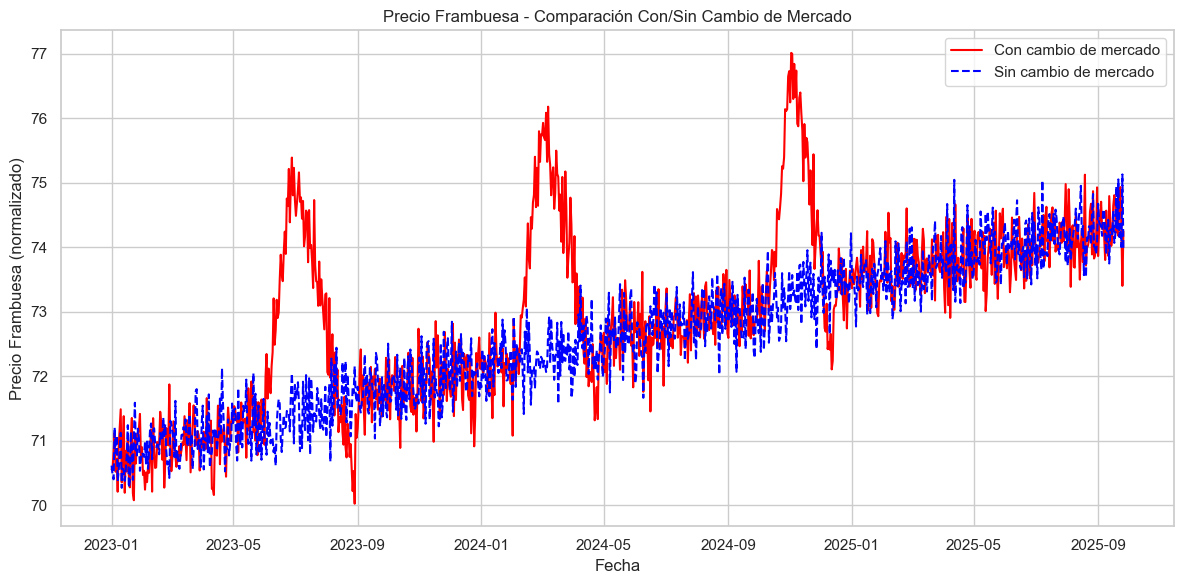

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Elegir una serie de cada tipo ---
serie_con_cambio = full_dataset[full_dataset['serie_id'] == 'con_cambio_1']
serie_sin_cambio = full_dataset[full_dataset['serie_id'] == 'sin_cambio_1']

# --- Graficar solo precio frambuesa ---
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

plt.plot(serie_con_cambio['fecha'], serie_con_cambio['precio_frambuesa'], label='Con cambio de mercado', color='red')
plt.plot(serie_sin_cambio['fecha'], serie_sin_cambio['precio_frambuesa'], label='Sin cambio de mercado', color='blue', linestyle='--')

plt.title('Precio Frambuesa - Comparación Con/Sin Cambio de Mercado')
plt.xlabel('Fecha')
plt.ylabel('Precio Frambuesa (normalizado)')
plt.legend()
plt.tight_layout()
plt.show()
